<a href="https://colab.research.google.com/github/Azie88/NLP-Huggingface-Covid-19-Tweet-Sentiment-Analysis/blob/main/dev/Tweet%20Sentiment%20Analysis%20Roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with HuggingFace & Colab

Deep learning has pretty much taken over NLP. Language models like those available through huggingface are able to capture nuances of text, and can be trained with very little effort. They are super easy to use.

Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps. It's really awesome.


The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. This project will use [Google Colab](https://colab.research.google.com/) to leverage the GPU computational power.

This project is about Natural Language Processing, specifically text classification (Sentiment analysis). In this project, we will fine-tune a pre-trained text classification Deep Learning model from HuggingFace on a new dataset to adapt the models to the task that we want to solve, i.e the prediction of the sentiment expressed in a Tweet (e.g: neutral, positive, negative), then create an app to use the models and deploy the app on the HuggingFace platform.

<br>

Read more about [Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

## Business Understanding

Vaccines have lowered the risk of illness and death, and have saved countless lives around the world. Unfortunately in some countries, the 'anti-vaxxer' movement has led to lower rates of vaccination and new outbreaks of old diseases.

The COVID vaccination has been very controversial and people have mixed feelings and opinions about it. Therefore, it is important to monitor public sentiment towards vaccinations now and in the future as the COVID-19 vaccines continue to be offered to the public. The anti-vaccination sentiment could pose a serious threat to the global efforts to get COVID-19 under control in the long term.

The objective of this challenge is to develop a machine learning model to assess if a Twitter post related to COVID vaccinations is positive, neutral, or negative. This solution could help governments and other public health actors monitor public sentiment towards COVID-19 vaccinations and help improve public health policy, vaccine communication strategies, and vaccination programs across the world.

## Data Understanding

### Install Libraries and Packages

In [1]:
!pip install datasets
!pip install accelerate>=0.20.1
!pip install transformers[torch]
!pip install -U huggingface_hub
!pip install tokenizers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.3 MB/s eta 0:00:00


### Import Libraries and Packages

In [2]:
#System and data handling
import os
import re
import pandas as pd
import numpy as np

#Data Preparation
from datasets import load_dataset, load_metric

#Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

#Google Drive
from google.colab import drive

#Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Transformers
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, TFAutoModelForSequenceClassification

#Scores
from scipy.special import softmax

# Deep learning
import torch
from torch import nn

#Huggingface
from huggingface_hub import notebook_login

### Setup

In [49]:
#login to huggingface with access token

notebook_login()

In [4]:
# Set a fixed random seed for PyTorch on CPU
torch.manual_seed(42)

# Control the seed for individual GPU operations (optional)
if torch.cuda.is_available:
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.cuda.manual_seed_all(42)


In [5]:
# Connect to your google drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

### Data Loading

In [7]:
# Load the dataset and display some values
df = pd.read_csv('/content/drive/MyDrive/Covid-19 tweet dataset/Train.csv')


In [8]:
#look at first 10 rows in train data
df.head(10)

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.000000
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.000000
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.000000
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.000000
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.000000
5,OVNPOAUX,<user> a nearly 67 year old study when mental ...,1.0,0.666667
6,JDA2QDV5,"Study of more than 95,000 kids finds no link b...",1.0,0.666667
7,S6UKR4OJ,psa: VACCINATE YOUR FUCKING KIDS,1.0,1.000000
8,V6IJATBE,Coughing extra on the shuttle and everyone thi...,1.0,0.666667
9,VB25IDQK,AIDS vaccine created at Oregon Health &amp; Sc...,1.0,0.666667


1. **tweet_id**: Unique identifier of the tweet

2. **safe_tweet**: Text contained in the tweet. Some sensitive information has been removed like usernames and urls

3. **label**: Sentiment of the tweet (-1 for negative, 0 for neutral, 1 for positive)

4. **agreement**: The tweets were labeled by three people. Agreement indicates the percentage of the three reviewers that agreed on the given label. You may use this column in your training, but agreement data will not be shared for the test set.

In [9]:
#Check rows and columns
df.shape

(10001, 4)

In [10]:
#Check Data types
df.dtypes

tweet_id      object
safe_text     object
label        float64
agreement    float64
dtype: object

In [11]:
#Descriptive Statistics
df.describe()

,label,agreement
count,10000.000000,9999.000000
mean,0.301567,0.854252
std,0.646718,0.180707
min,-1.000000,0.333333
25%,0.000000,0.666667
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [12]:
#Check Null values
df.isna().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

In [13]:
# Check the 'label' value counts
df.label.value_counts()

 0.000000    4908
 1.000000    4053
-1.000000    1038
 0.666667       1
Name: label, dtype: int64

In [14]:
# Check for quality of 'safe_text' tweets
df.safe_text.sample(10)

8247    Anti-vaxxers now have a children's book extoll...
9777              😂 "<user> Shonda tackling measles too?”
829     I don't understand why people can't just vacci...
3964    <user> : then why do so many people listen to ...
1821                         H shir mmr we have keystones
7315    "<user> from a people nearly wiped out by dise...
7505               <user> not when its houses the measles
4615    "<user> Share this tweet, and thank a health w...
4263    I don't know why people think not vaccinating ...
6038    So yeah, you're rude and unnecessarily spreadi...
Name: safe_text, dtype: object

## Data Preparation

1. Remove rows with NaN values.
2. Clean *safe-text* column of Twitter Handles, HTML characters, URLs and other non alphabetic characters. Text is inconsistent and may affect model performance.

In [15]:
# Eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]

In [16]:
# Check null values
df.isna().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [17]:
# Function to clean text
# Replace unwanted characters with empty string

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove tweet mentions
    text = re.sub(r'<user>', '', text)
    text = re.sub(r'<url>', '', text)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Replace all whitespace characters with a single space
    text = re.sub(r'\s+', ' ', text)

    return text

In [18]:
# Apply the clean_text function to the 'safe_text' column
df['safe_text'] = df.safe_text.apply(clean_text)

In [19]:
df.safe_text.sample(20)

8308     Remember the immunization hypothesis of autis...
1535    One new measles case announced Monday in Tarra...
4038    Flu shot Immunity upgraded Pattie Groves Healt...
2102     Mom genes dont cause ASD toxic ingredients in...
615      Is forcing CNN to suppress information about ...
7495    Malaria Vaccine Shows Promise in Shielding Afr...
1428     the immunity is for her truthful testimony sh...
572                                                   MMR
9715    Parenting privileges should be taken away for ...
6216    Bring it on typhoid fever And all the other va...
4252    Did this really come out of Rand Pauls mouth T...
7063     People who complain live longer Releasing ten...
8712    Well since antivaccination is being condoned I...
3166    Our hot Saturday night spent constructing Ikea...
1822    USA Where people freak out about Ebola but don...
2441     Theres no link between vaccines and childhood...
2229     Are you willing to sacrifice your own childre...
8668    I feel

In [20]:
# Check label value counts after deleting NaN values
df.label.value_counts()

 0.0    4908
 1.0    4053
-1.0    1038
Name: label, dtype: int64

The target classes are imbalanced.

### Exploratory Data Analysis

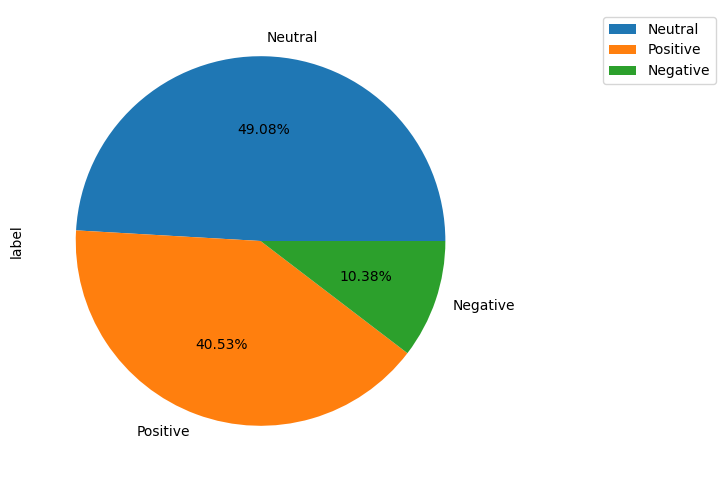

In [21]:
# pie chart wth 'labels' column
plt.figure(figsize=(6,6))
explode=0.1,0
df.label.value_counts().plot.pie(autopct='%1.2f%%',labels=['Neutral','Positive','Negative'])
plt.legend(bbox_to_anchor=(1.5,1))
plt.show()

Neutral and positive sentiments are more prevalent, while negative sentiments are relatively less frequent in the dataset.

(-0.5, 399.5, 199.5, -0.5)

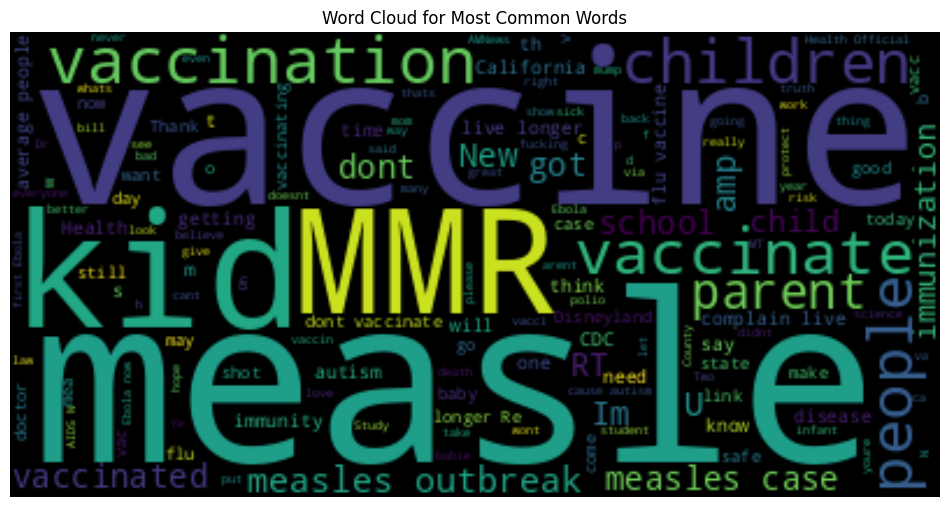

In [22]:
#generate a word cloud visualization from the 'safe_text' column

all_data = df['safe_text'].to_string()
wordcloud = WordCloud().generate(all_data)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.title('Word Cloud for Most Common Words')
plt.axis("off")

The word cloud provides a visual representation of the most frequent terms in the tweets. The size of each word in the cloud is proportional to its frequency. Lets look at how many words are in each tweet.

In [23]:
# Number of words in each tweet in the 'safe_text' column
text_lengths = df['safe_text'].str.split().str.len()
text_lengths.value_counts().sort_values(ascending=False)

16    789
17    711
18    669
15    653
13    636
14    580
19    565
10    522
20    502
11    502
12    501
9     419
21    414
8     408
22    362
7     283
23    251
6     224
24    212
5     180
4     141
25    135
3      93
26     83
27     46
2      39
1      31
28     24
29     12
30      7
31      5
Name: safe_text, dtype: int64

In [24]:
# Calculate the average
average_length = np.mean(text_lengths)

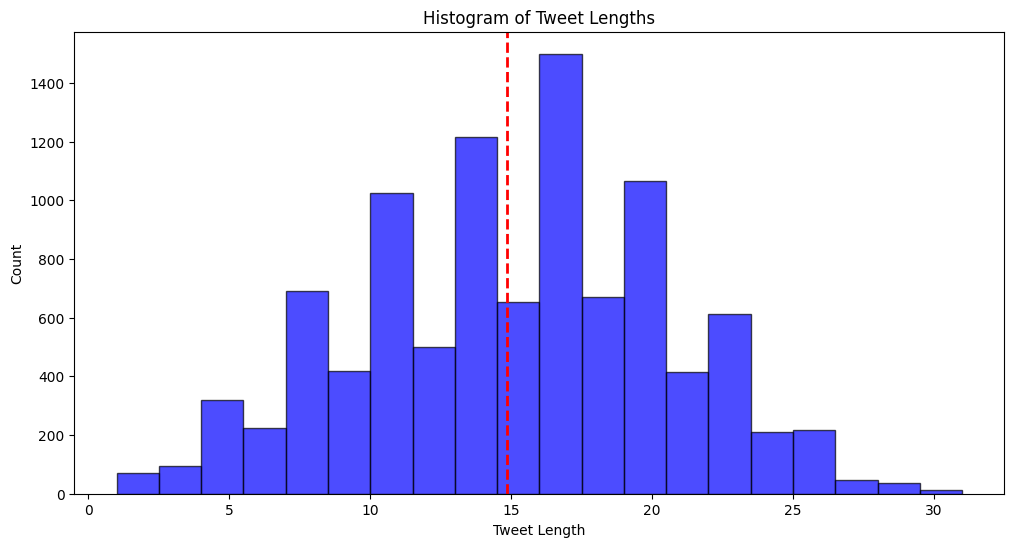

In [25]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Using plt.hist to create a histogram with Matplotlib
ax.hist(text_lengths, bins=20, color="blue", edgecolor="black", alpha=0.7)

# Add average line
ax.axvline(average_length, color='red', linestyle='dashed', linewidth=2, label=f'Average: {average_length:.2f}')

ax.set_title('Histogram of Tweet Lengths')
ax.set_xlabel('Tweet Length')
ax.set_ylabel('Count')

# Display the plot
plt.show()


### Train Test Split

In [26]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [27]:
#preview the train subset
train.head()

,tweet_id,safe_text,label,agreement
9305,YMRMEDME,Mickeys Measles has gone international,0.0,1.000000
3907,5GV8NEZS,S NEW Extends exemption from charitable immuni...,0.0,1.000000
795,EI10PS46,your ignorance on vaccines isnt just dangerou...,1.0,0.666667
5793,OM26E6DG,Pakistan partly suspends polio vaccination pro...,0.0,1.000000
3431,NBBY86FX,In other news Ive gone up like mmr,0.0,1.000000


In [28]:
#preview the eval subset
eval.head()

,tweet_id,safe_text,label,agreement
6571,R7JPIFN7,Childrens Museum of Houston to Offer Free Vacc...,1.0,1.000000
1754,2DD250VN,no I was properly immunized prior to the perf...,1.0,1.000000
3325,ESEVBTFN,thx for posting vaccinations are imperative A...,1.0,1.000000
1485,S17ZU0LC,This Baby Is Exactly Why Everyone Needs To Vac...,1.0,0.666667
4175,IIN5D33V,Meeting tonight pm in room of the student cent...,1.0,1.000000


In [29]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (7999, 4), eval is (2000, 4)


In [30]:
# Save split subsets
train.to_csv("/content/drive/MyDrive/Covid-19 tweet dataset/train_subset.csv", index=False)
eval.to_csv("/content/drive/MyDrive/Covid-19 tweet dataset/eval_subset.csv", index=False)

In [31]:
# Load split subsets
dataset = load_dataset('csv',
                        data_files={'train': '/content/drive/MyDrive/Covid-19 tweet dataset/train_subset.csv',
                        'eval': '/content/drive/MyDrive/Covid-19 tweet dataset/eval_subset.csv'}, encoding = "ISO-8859-1")


Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

## Model Fine Tuning and Training

In [32]:
# Define pre-trained model name and instance of tokenizer from the model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

**Model**: Twitter-roBERTa-base for Sentiment Analysis - UPDATED (2022) [Model link on huggingface](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)

**Description**: This is a RoBERTa-base model trained on ~124M tweets from January 2018 to December 2021, and finetuned for sentiment analysis with the TweetEval benchmark.

**Labels**:
*   Negative --> 0
*   Neutral --> 1
*   Positive --> 2




In [33]:
# Function to transform the labels:
# Negative -1:0
# Neutral 0:1
# Positive 1:2

def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

In [34]:
# Function to tokenize data

def tokenize_data(example):
    return tokenizer(example['safe_text'], padding=True, max_length = 'max_length')

In [35]:
# Change the tweets to tokens that the model can use
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2632: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [36]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

#### Balancing Target Classes

Since our target has imbalanced class weights (positive, neutral and negative dont have an equal number of samples), we want to give more weight to underrepresented classes and give less weight to classes with more samples.

In [37]:
# Define the labels
labels = dataset['train']['labels']

# Apply the compute class weight function to calculate the class weight
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

The `balanced` option in compute_class_weight will calculate weights such that the classes are balanced.

In [38]:
# Preview class weights
class_weights, np.unique(labels)

(array([3.20858404, 0.67914756, 0.82243471]), array([0, 1, 2]))

In [39]:
# Define an instance of the pre-trained model with the number of labels
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
# Configure the training parameters

training_args = TrainingArguments("COVID_Vaccine_Tweet_sentiment_analysis_roberta",
    num_train_epochs=5, # the number of times the model will repeat the training loop over the dataset
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [41]:
# evaluation metrics

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-41-ce8e5b3f167f>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [42]:
# Instantiate the training and validation sets with random state of 10
train_dataset = dataset['train'].shuffle(seed=10)
eval_dataset = dataset['eval'].shuffle(seed=10)

In [43]:
# Convert train data to PyTorch tensors to speed up training and add padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,padding=True, max_length='max_length', return_tensors='pt')

In [44]:
# Define Custom Trainer | Modify loss function and assign computed weights
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [45]:
# Instantiate the trainer for training
c_trainer = CustomTrainer(
                  model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset,
                  tokenizer = tokenizer,
                  compute_metrics=compute_metrics,
)

In [46]:
# Launch the learning process: training
c_trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.760600,0.728689,0.773000
2,0.609900,0.828478,0.767000
3,0.423800,0.933114,0.779500
4,0.313900,1.387053,0.780500
5,0.172700,1.484532,0.781000


TrainOutput(global_step=5000, training_loss=0.46577435302734377, metrics={'train_runtime': 599.7504, 'train_samples_per_second': 66.686, 'train_steps_per_second': 8.337, 'total_flos': 964328662241910.0, 'train_loss': 0.46577435302734377, 'epoch': 5.0})

`Training Loss`: The training loss is decreasing with each epoch, which is a positive sign. It suggests that the model is learning and improving its predictions on the training data.

`Validation Loss`: The validation loss is relatively stable for the first 3 epochs but starts to increase thereafter. This could indicate overfitting, where the model is performing well on the training data but not generalizing as effectively on evaluation(unseen) data.

`Accuracy`: The accuracy on the validation data is around 78% in the final epoch, which is a reasonable accuracy. The model is correctly predicting sentiments for approximately 78% of the validation samples.

In [47]:
# Launch the final evaluation
c_trainer.evaluate()

{'eval_loss': 0.7286885976791382,
 'eval_accuracy': 0.773,
 'eval_runtime': 6.5655,
 'eval_samples_per_second': 304.621,
 'eval_steps_per_second': 38.078,
 'epoch': 5.0}

In [50]:
# Push model and tokenizer to HF Hub
model.push_to_hub("Azie88/COVID_Vaccine_Tweet_sentiment_analysis_roberta")
tokenizer.push_to_hub("Azie88/COVID_Vaccine_Tweet_sentiment_analysis_roberta")
dataset.push_to_hub("Azie88/COVID_Vaccine_Tweet_sentiment_analysis_roberta")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Azie88/COVID_Vaccine_Tweet_sentiment_analysis_roberta/commit/f3f6e9b2d02f5fc02c9ef2e48a193d01b38db9d9', commit_message='Upload dataset', commit_description='', oid='f3f6e9b2d02f5fc02c9ef2e48a193d01b38db9d9', pr_url=None, pr_revision=None, pr_num=None)

This notebook is inspired by an article: [Fine-Tuning Bert for Tweets Classification ft. Hugging Face](https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf)

## Inference
Let's test out our model with with some sample text

In [51]:
model_path = f"Azie88/COVID_Vaccine_Tweet_sentiment_analysis_roberta"

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [52]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [53]:
# Input preprocessing
text = "Covid vaccine is very effective"
text = preprocess(text)

In [54]:
# PyTorch-based models
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

In [55]:
print("Scores:", scores)
print("id2label Dictionary:", config.id2label)


Scores: [0.07086153 0.14127311 0.7878654 ]
id2label Dictionary: {0: 'negative', 1: 'neutral', 2: 'positive'}


In [56]:
config.id2label = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}

In [57]:
# Print labels and scores
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) POSITIVE 0.7879
2) NEUTRAL 0.1413
3) NEGATIVE 0.0709


In [60]:
!pip freeze > requirements.txt